## Bitcoin Analysis with ARIMA

I attempt to use ARIMA to try and model the price of Bitcoin for 2019. I _do not_ use any automated ARIMA methods, since I much prefer being able to explain the choices for my model.

Ultimately, my model does not show any signs of effectiveness; however, it was good practice in performing some of the things I'm used to doing in R, in Python.

In [77]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as tsaplots
from datetime import datetime
from statsmodels.graphics.api import qqplot

sns.set_style("darkgrid")

In [2]:
today = str(datetime.now()).split(" ")[0].replace("-","")

In [3]:
raw = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end={0}".format(today))

In [4]:
raw = raw[0]

In [5]:
raw.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'marketcap']

In [6]:
raw['date'] = pd.to_datetime(raw['date'])

In [7]:
df = raw.set_index('date')

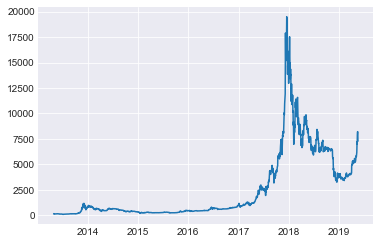

In [8]:
plt.plot(df['close'])

Let's start the analysis after the 'tulip' mania and the great correction.

In [9]:
df = df.loc[df.index >= '2019-01-01']

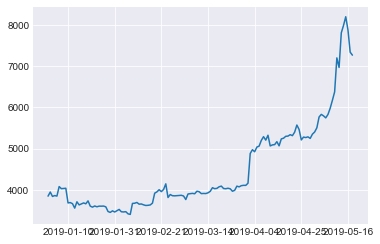

In [10]:
plt.plot(df['close'])

In [53]:
res = sm.tsa.seasonal_decompose(df['close'], freq = 52)

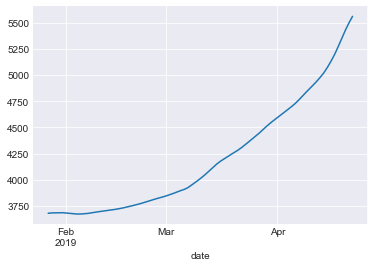

In [54]:
res.trend.plot()

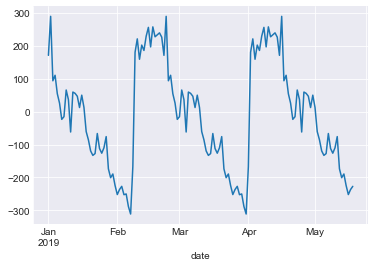

In [55]:
res.seasonal.plot()

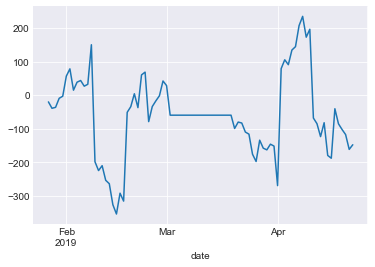

In [56]:
res.resid.plot()

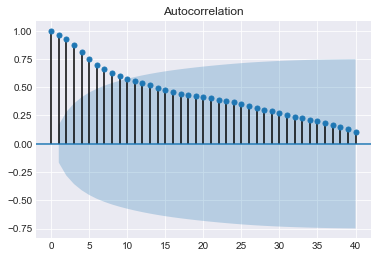

In [57]:
acf = tsaplots.plot_acf(df['close'], lags = 40)

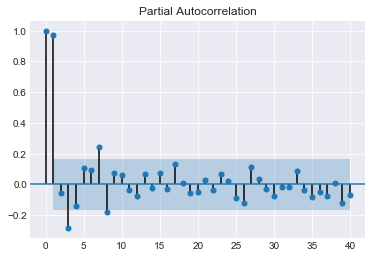

In [58]:
pacf = tsaplots.plot_pacf(df['close'], lags = 40)

In [59]:
tsa.stattools.adfuller(df['close'])[1]

0.05997405072112255

We're clearly not stationary, so let's try "removing" some variance by logging.

In [60]:
btc = df.close

In [61]:
ldf = np.log(btc)

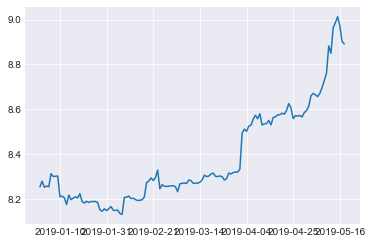

In [62]:
plt.plot(ldf)

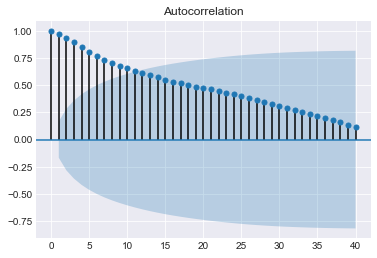

In [63]:
acf = tsaplots.plot_acf(ldf, lags = 40)

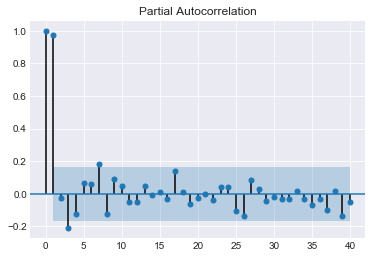

In [64]:
pacf = tsaplots.plot_pacf(ldf, lags = 40)

In [65]:
tsa.stattools.adfuller(ldf)[1]

0.11145564295198962

Logging confirmed that we have an AR(2) situation going on. (ACF is dying down while PACF cuts off at lag 2). I'd still like to remove the trend in order to get a stationary series.

In [66]:
dldf = ldf.diff()[1:]

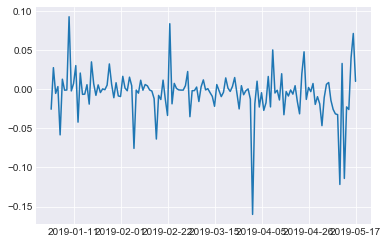

In [67]:
plt.plot(dldf)

In [68]:
tsa.stattools.adfuller(dldf)[1]

6.0371231296368555e-22

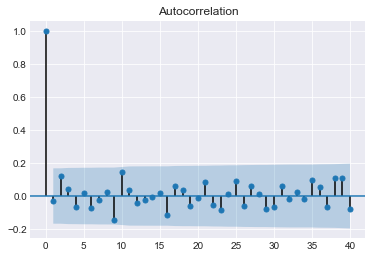

In [69]:
acf = tsaplots.plot_acf(dldf, lags = 40)

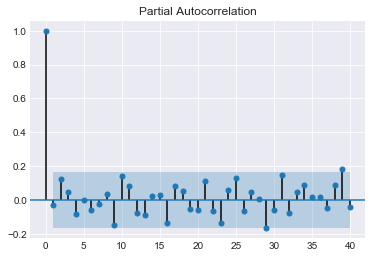

In [70]:
pacf = tsaplots.plot_pacf(dldf, lags = 40)

In [71]:
model = sm.tsa.ARIMA(ldf, order = (2, 1, 0))
fit = model.fit(method = "mle")

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


In [72]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                  137
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 288.388
Method:                           mle   S.D. of innovations              0.029
Date:                Sun, 19 May 2019   AIC                           -568.776
Time:                        16:48:42   BIC                           -557.096
Sample:                    05-17-2019   HQIC                          -564.030
                         - 01-01-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0045      0.003     -1.623      0.107      -0.010       0.001
ar.L1.D.close    -0.0233      0.085     -0.275      0.784      -0.189       0.143
ar.L2.D.close     0.1262      0.087      1.453      0.149      -0.044       0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7245           +0.0000j            2.7245            0.5000
AR.2            2.9091           +0.0000j            2.9091            0.0000
-----------------------------------------------------------------------------
"""

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


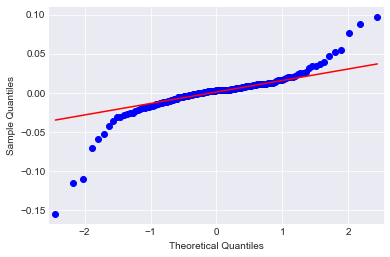

In [78]:
qqplot(fit.resid, line='q');

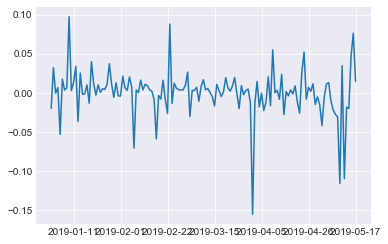

In [80]:
plt.plot(fit.resid)

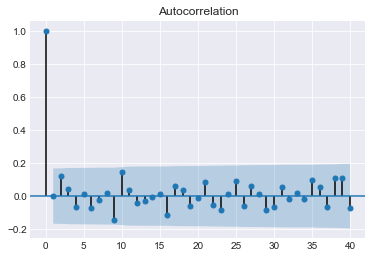

In [81]:
acf = tsaplots.plot_acf(fit.resid, lags = 40)

In [82]:
tsa.stattools.adfuller(fit.resid)[1]

3.850199210275184e-21

We note that since zero is in both of our model's confidence intervals, we're not really predicting anything well. 

In conclusion, we'll have to come up with a better way to model the price of bitcoin.

I may try to use SARIMA to capture some seasonality in the future.